# Download and inspect some model results from Ponte and Klein, 2015

https://dataverse.scholarsportal.info/dataset.xhtml?persistentId=doi:10.5683/SP2/HU58SG

TODO:

- Function to read data into a "nicer" xarray format
- Movie of low freq SSH and tidal SSH
-  "        "  vorticity and tidal northward velocity 
- Time series reconsutrction of total SSH/velocity
- PSD of raw signal

In [1]:
## Download the data
#!curl https://dataverse.scholarsportal.info/api/access/datafile/170108 -o ../DATA/wp50-t1.nc
# !wget https://dataverse.scholarsportal.info/api/access/datafile/170118 ../DATA/wp50-t2.nc
# !wget https://dataverse.scholarsportal.info/api/access/datafile/170113 ../DATA/wp90-t1.nc
# !wget https://dataverse.scholarsportal.info/api/access/datafile/170112 ../DATA/wp90-t2.nc

In [136]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from cmocean import cm
from scipy.interpolate import interp1d
from scipy import signal
from matplotlib.animation import FuncAnimation, PillowWriter, writers, FFMpegWriter

In [137]:
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['font.size'] = 14

In [172]:
# ds = xr.open_mfdataset('../DATA/wp50-t*.nc', concat_dim='time_centered_bounds')
scenario = 'wp50'

ds = xr.open_dataset('../DATA/{}-t2.nc'.format(scenario))

ds

<xarray.Dataset>
Dimensions:               (y_rho: 722, x_rho: 258, y_u: 722, x_u: 257, y_v: 721, x_v: 258, s_rho_slice0: 1, time_counter: 50, axis_nbounds: 2)
Coordinates:
    nav_lat_rho           (y_rho, x_rho) float32 ...
    nav_lat_u             (y_u, x_u) float32 ...
    nav_lat_v             (y_v, x_v) float32 ...
    nav_lon_rho           (y_rho, x_rho) float32 ...
    nav_lon_u             (y_u, x_u) float32 ...
    nav_lon_v             (y_v, x_v) float32 ...
  * s_rho_slice0          (s_rho_slice0) float32 -0.01
    time_centered         (time_counter) datetime64[ns] ...
  * time_counter          (time_counter) datetime64[ns] 1950-01-01T12:00:00 ....
    time_instant          (time_counter) datetime64[ns] ...
Dimensions without coordinates: y_rho, x_rho, y_u, x_u, y_v, x_v, axis_nbounds
Data variables: (12/21)
    time_centered_bounds  (time_counter, axis_nbounds) datetime64[ns] ...
    time_counter_bounds   (time_counter, axis_nbounds) datetime64[ns] ...
    u_xy_cos              (time_counter, s_rho_slice0, y_u, x_u) float32 ...
    u_xy_sin              (time_counter, s_rho_slice0, y_u, x_u) float32 ...
    v_xy_cos              (time_counter, s_rho_slice0, y_v, x_v) float32 ...
    v_xy_sin              (time_counter, s_rho_slice0, y_v, x_v) float32 ...
    ...                    ...
    T_xy_ins              (time_counter, s_rho_slice0, y_rho, x_rho) float32 ...
    ssh_ins               (time_counter, y_rho, x_rho) float32 ...
    time_instant_bounds   (time_counter, axis_nbounds) datetime64[ns] ...
    u_xy_ins              (time_counter, s_rho_slice0, y_u, x_u) float32 ...
    v_xy_ins              (time_counter, s_rho_slice0, y_v, x_v) float32 ...
    w_xy_ins              (time_counter, s_rho_slice0, y_rho, x_rho) float32 ...
Attributes:
    name:                       file_surf
    description:                Created by xios
    title:                      Created by xios
    Conventions:                CF-1.5
    production:                 An IPSL model
    timeStamp:                  2021-May-27 09:56:25 GMT
    history:                    Fri May 28 17:48:28 2021: ncks -A /data2/nico...
    NCO:                        4.7.2
    nco_openmp_thread_number:   1
    history_of_appended_files:  Fri May 28 17:48:28 2021: Appended file /data...

In [173]:
# Create nicer dimensions
def load_data(ncfile,datavar='ssh'):
    ds = xr.open_dataset(ncfile)
    dx = 4.0
    if len(ds['{}_lof'.format(datavar)].dims)==4:
        tdim, zdim, ydim, xdim = ds['{}_lof'.format(datavar)].dims
    else:
        tdim, ydim, xdim = ds['{}_lof'.format(datavar)].dims
    x = ds[xdim].values*dx
    y = ds[ydim].values*dx

    t0 = np.datetime64('1950-01-01 00:00:00')
    tdays = (ds.time_centered.values - t0).astype(float)*1e-9/86400.
    print(ncfile, tdays[0], tdays[-1])
    return xr.Dataset(
        {'{}_lof'.format(datavar):
            xr.DataArray(ds['{}_lof'.format(datavar)].squeeze(), coords={'x':x,'y':y, 'time':tdays}, dims=('time','y','x')),
         '{}_cos'.format(datavar):
            xr.DataArray(ds['{}_cos'.format(datavar)].squeeze(), coords={'x':x,'y':y, 'time':tdays}, dims=('time','y','x')),
         '{}_sin'.format(datavar):
            xr.DataArray(ds['{}_sin'.format(datavar)].squeeze(), coords={'x':x,'y':y, 'time':tdays}, dims=('time','y','x')),
        })


In [174]:
ds_v = xr.concat([load_data(ff, datavar='v_xy') for ff in glob('../DATA/{}-t*.nc'.format(scenario))], dim='time')
ds_u = xr.concat([load_data(ff, datavar='u_xy') for ff in glob('../DATA/{}-t*.nc'.format(scenario))], dim='time')
ds_ssh = xr.concat([load_data(ff, datavar='ssh') for ff in glob('../DATA/{}-t*.nc'.format(scenario))], dim='time')

nt =  ds_ssh.time.shape[0]
dt=2
ds_ssh['time']= np.arange(0, nt*dt,dt)
ds_u['time']= np.arange(0, nt*dt,dt)
ds_v['time']= np.arange(0, nt*dt,dt)


ds_ssh

../DATA/wp50-t1.nc 1.0 99.0
../DATA/wp50-t2.nc 1.0 99.0
../DATA/wp50-t1.nc 1.0 99.0
../DATA/wp50-t2.nc 1.0 99.0
../DATA/wp50-t1.nc 1.0 99.0
../DATA/wp50-t2.nc 1.0 99.0


<xarray.Dataset>
Dimensions:  (x: 258, y: 722, time: 100)
Coordinates:
  * x        (x) float64 0.0 4.0 8.0 12.0 ... 1.02e+03 1.024e+03 1.028e+03
  * y        (y) float64 0.0 4.0 8.0 12.0 ... 2.876e+03 2.88e+03 2.884e+03
  * time     (time) int64 0 2 4 6 8 10 12 14 ... 184 186 188 190 192 194 196 198
Data variables:
    ssh_lof  (time, y, x) float32 0.3899 0.3899 0.3899 ... -0.3896 -0.3895
    ssh_cos  (time, y, x) float32 1.194e-06 1.192e-06 ... -0.00129 -0.001278
    ssh_sin  (time, y, x) float32 -1.248e-06 -1.317e-06 ... -5.793e-05

# output saved as

$$
v(x,y,t) = v(x,y) + v_c(x,y) \cos(\omega t) + v_s(x,y) \sin(\omega t)
$$

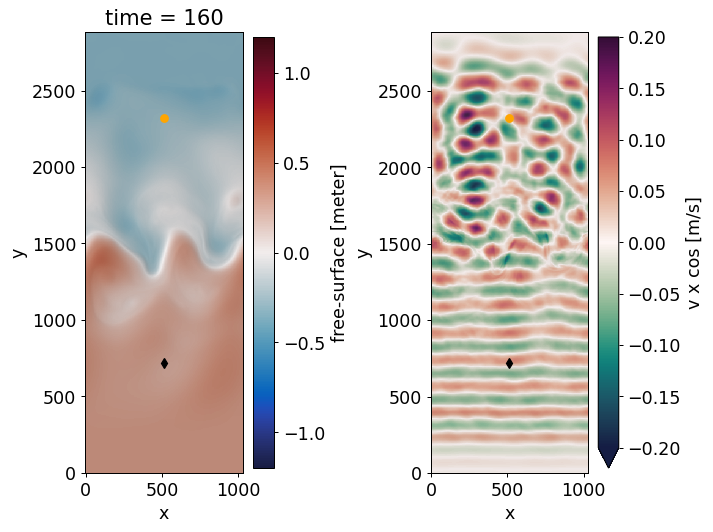

In [175]:
def initplot(tstep=0):
    fig = plt.figure(figsize=(8,10), dpi=90)
    ax1=plt.subplot(121)
    c1=ds_ssh['ssh_lof'][tstep,...].plot(vmin=-1.2, vmax=1.2, cmap=cm.balance, cbar_kwargs={'shrink':0.5})
    c2=ds_v['v_xy_lof'][tstep,...].plot(cmap='gist_gray', alpha=0.25, add_colorbar=False)
    ax1.set_aspect('equal')

    ax2=plt.subplot(122)
    #amp = np.abs( ds_v['v_xy_cos'][tstep,...] +1j * ds_v['v_xy_sin'][tstep,...])
    #c3=amp.plot(vmin=0, vmax=0.2, cmap=cm.speed, cbar_kwargs={'shrink':0.5})
    c3=ds_v['v_xy_cos'][tstep,...].plot(vmin=-0.2, vmax=0.2, cmap=cm.curl, cbar_kwargs={'shrink':0.5})
    c4= ds_ssh['ssh_cos'][tstep,...].plot(cmap='gist_gray', alpha=0.1, add_colorbar=False)
    ax2.set_aspect('equal')
    ax2.set_title('')
    plt.tight_layout()
    return fig, ax1, ax2, c1, c2, c3, c4

fig, ax1, ax2, c1, c2, c3, c4 = initplot(tstep=80)
ax1.plot(ds_ssh['x'][128], ds_ssh['y'][180],'kd')
ax1.plot(ds_ssh['x'][128], ds_ssh['y'][580],'orange',marker='o')

ax2.plot(ds_ssh['x'][128], ds_ssh['y'][180],'kd')
ax2.plot(ds_ssh['x'][128], ds_ssh['y'][580],'orange',marker='o')
plt.savefig('../FIGURES/PK2015_snapshot_{}.png'.format(scenario), dpi=150)

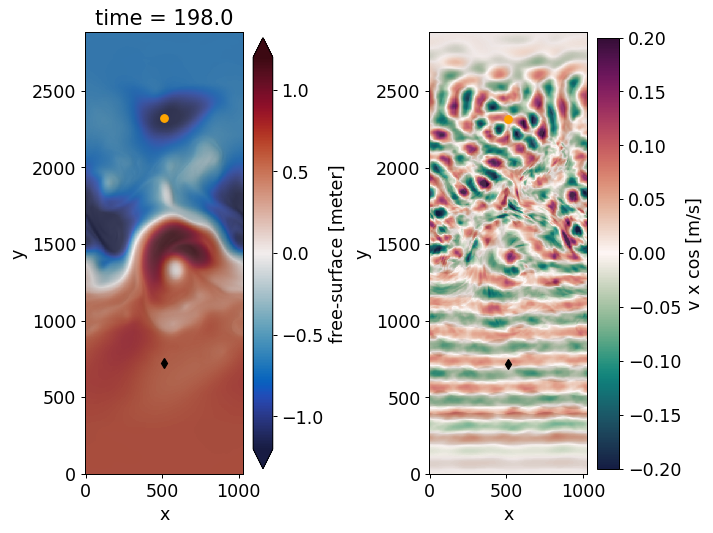

In [142]:
fig, ax1, ax2, c1, c2, c3, c4 = initplot(tstep=0)

ax1.plot(ds_ssh['x'][128], ds_ssh['y'][180],'kd')
ax1.plot(ds_ssh['x'][128], ds_ssh['y'][580],'orange',marker='o')

ax2.plot(ds_ssh['x'][128], ds_ssh['y'][180],'kd')
ax2.plot(ds_ssh['x'][128], ds_ssh['y'][580],'orange',marker='o')

def update(tstep):
        
    c1.set_array(ds_ssh['ssh_lof'][tstep,...].values.ravel())
    c2.set_array(ds_v['v_xy_lof'][tstep,...].values.ravel())
    #amp = np.abs( ds_v['v_xy_cos'][tstep,...] +1j * ds_v['v_xy_sin'][tstep,...])
    c3.set_array(ds_v['v_xy_cos'][tstep,...].values.ravel())
    c4.set_array(ds_ssh['ssh_cos'][tstep,...].values.ravel())

    ax1.set_title('time = {:3.1f}'.format(ds_ssh.time.values[tstep]))
    
    #return ax1, c1, c2, c3, c4

anim = FuncAnimation(fig, update, frames=range(0, nt),  blit=False)
FFwriter = FFMpegWriter(fps=6, bitrate=-1, extra_args=['-vcodec', 'libx264','-pix_fmt', 'yuv420p'])
# FFwriter = FFMpegWriter(fps=6)

anim.save('../FIGURES/{}.mp4'.format(scenario), writer = FFwriter)

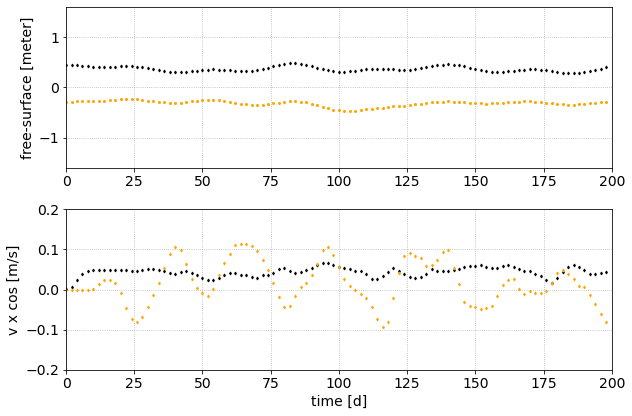

In [176]:
fig=plt.figure(figsize=(9,6))
ax=plt.subplot(211)
ds_ssh['ssh_lof'][:,180,128].plot(color='k', marker='d', ls='', ms=2)
ds_ssh['ssh_lof'][:,580,128].plot(color='orange', marker='o', ls='', ms=2)
ax.set_title('')
plt.xlim(0,200)
plt.ylim(-1.6, 1.6)
plt.xlabel('')
plt.grid(b=True , ls=':')

ax=plt.subplot(212)
ds_v['v_xy_cos'][:,180,128].plot(color='k', marker='d', ls='', ms=2)
ds_v['v_xy_cos'][:,580,128].plot(color='orange', marker='d', ls='', ms=2)
ax.set_title('')
plt.ylim(-0.2,0.2)
plt.xlim(0,200)
plt.xlabel('time [d]')
plt.grid(b=True , ls=':')

plt.tight_layout()

plt.savefig('../FIGURES/PK2015_timeseries_{}.png'.format(scenario), dpi=150)

In [177]:
from statsmodels.tsa import stattools


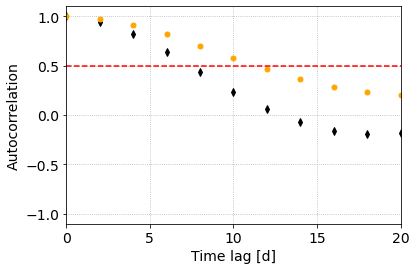

In [178]:
plt.figure()
plt.plot(np.arange(0,11*dt,dt), stattools.acf(ds_ssh['ssh_lof'][:,180,128].values, nlags=10),
        color='k', marker='d', ls='', ms=5)
plt.plot(np.arange(0,11*dt,dt), stattools.acf(ds_ssh['ssh_lof'][:,580,128].values, nlags=10),
        color='orange', marker='o', ls='', ms=5)
# plt.plot(stattools.acf(ds['ssh_cos'][:,360,128].values, nlags=20))
# plt.plot(stattools.acf(ds['ssh_sin'][:,360,128].values, nlags=20))

plt.axhline(0.5,c='r', ls='--')
plt.ylim(-1.1,1.1)
plt.xlim(0, 20)
plt.ylabel('Autocorrelation')
plt.xlabel('Time lag [d]')
plt.grid(b=True, ls=':')

plt.savefig('../FIGURES/PK2015_acor_lowf_{}.png'.format(scenario), dpi=150)

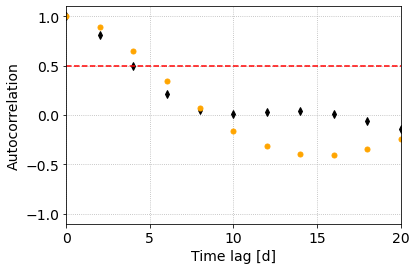

In [179]:
plt.figure()
plt.plot(np.arange(0,11*dt,dt), stattools.acf(ds_v['v_xy_cos'][:,180,128].values, nlags=10),
        color='k', marker='d', ls='', ms=5)
plt.plot(np.arange(0,11*dt,dt), stattools.acf(ds_v['v_xy_cos'][:,580,128].values, nlags=10),
        color='orange', marker='o', ls='', ms=5)
# plt.plot(stattools.acf(ds['ssh_cos'][:,360,128].values, nlags=20))
# plt.plot(stattools.acf(ds['ssh_sin'][:,360,128].values, nlags=20))

plt.axhline(0.5,c='r', ls='--')
plt.ylim(-1.1,1.1)
plt.xlim(0, 20)
plt.ylabel('Autocorrelation')
plt.xlabel('Time lag [d]')
plt.grid(b=True, ls=':')

plt.savefig('../FIGURES/PK2015_acor_vcos_{}.png'.format(scenario), dpi=150)

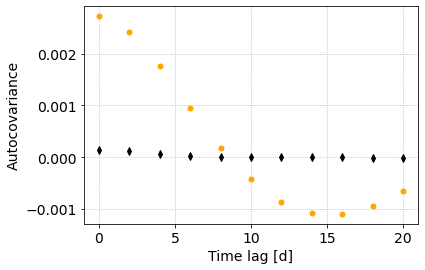

In [180]:
plt.figure()
plt.plot(np.arange(0,11*dt,dt), stattools.acovf(ds_v['v_xy_cos'][:,180,128].values, nlag=10),
        color='k', marker='d', ls='', ms=5)
plt.plot(np.arange(0,11*dt,dt), stattools.acovf(ds_v['v_xy_cos'][:,580,128].values, nlag=10),
        color='orange', marker='o', ls='', ms=5)
# plt.plot(stattools.acf(ds['ssh_cos'][:,360,128].values, nlags=20))
# plt.plot(stattools.acf(ds['ssh_sin'][:,360,128].values, nlags=20))

# plt.axhline(0.5,c='r', ls='--')
# plt.ylim(-1.1,1.1)
# plt.xlim(0, 20)
plt.ylabel('Autocovariance')
plt.xlabel('Time lag [d]')
plt.grid(b=True, ls=':')

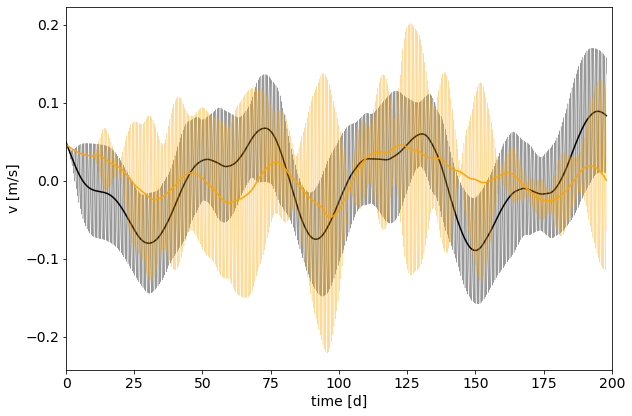

In [181]:
# Reconstruct a time series at a point


def calc_raw_v(xpt, ypt, dtout):
    omega = 2*np.pi*2. # 2 cpd

    tfast = np.arange(0, ds_v.time.values[-1], dtout)

    F = interp1d(ds_v.time.values, ds_v.v_xy_lof[:,ypt, xpt], kind=2)
    vlow = F(tfast)
    F = interp1d(ds_v.time.values, ds_v.v_xy_cos[:,ypt, xpt], kind=2)
    vcos = F(tfast)
    F = interp1d(ds_v.time.values, ds_v.v_xy_sin[:,ypt, xpt], kind=2)
    vsin = F(tfast)

    vraw = vlow + vcos*np.cos(omega*tfast) + vsin*np.sin(omega*tfast)
    
    return tfast, vraw, vlow

dt_days = 1/72 # 20 minutes

plt.figure(figsize=(9,6))
tfast, vraw, vlow = calc_raw_v(128, 180, dt_days)
tfast, vraw2, vlow2 = calc_raw_v(128, 580, dt_days)

plt.plot(tfast, vraw, c='k', lw=0.2)
plt.plot(tfast, vlow, c='k')

plt.plot(tfast, vraw2, c='orange', lw=0.2)
plt.plot(tfast, vlow2, c='orange')
# plt.xlim(10,12)
plt.xlim(0,200)
plt.ylabel('v [m/s]')
plt.xlabel('time [d]')
plt.tight_layout()

plt.savefig('../FIGURES/PK2015_raw_v_{}.png'.format(scenario), dpi=150)

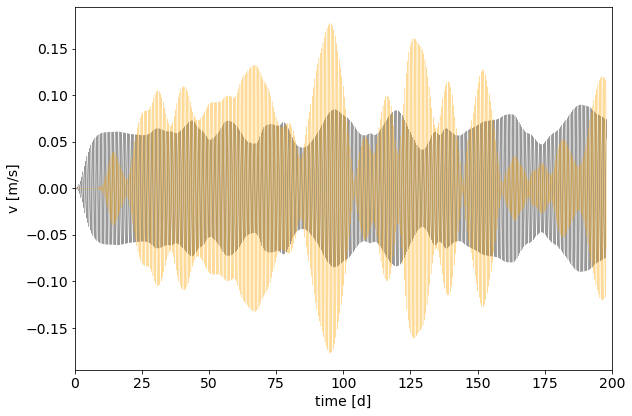

In [182]:
plt.figure(figsize=(9,6))
tfast, vraw, vlow = calc_raw_v(128, 180, dt_days)
tfast, vraw2, vlow2 = calc_raw_v(128, 580, dt_days)

plt.plot(tfast, vraw-vlow, c='k', lw=0.2)
# plt.plot(tfast, vlow, c='k')

plt.plot(tfast, vraw2-vlow2, c='orange', lw=0.2)
# plt.plot(tfast, vlow2, c='orange')
# plt.xlim(10,12)
plt.xlim(0,200)
plt.ylabel('v [m/s]')
plt.xlabel('time [d]')
plt.tight_layout()

plt.savefig('../FIGURES/PK2015_tidal_v_{}.png'.format(scenario), dpi=150)

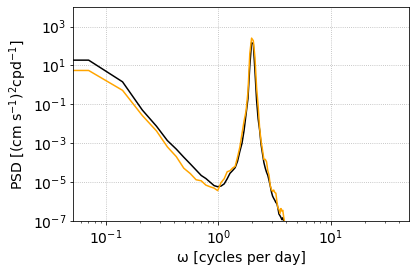

In [183]:
nperseg = 1024
y = vraw * 100.
f, Puu= signal.welch(y-y.mean(), fs=1/dt_days, nperseg=nperseg)

y = vraw2 * 100.
f, Puu2 = signal.welch(y-y.mean(), fs=1/dt_days, nperseg=nperseg)

plt.figure()
ax=plt.subplot(111)
plt.loglog(f, Puu, c='k')
plt.loglog(f, Puu2, c='orange')

plt.xlabel('ω [cycles per day]')
plt.ylabel('PSD [(cm s$^{-1}$)$^2$cpd$^{-1}$]')
plt.grid(b=True,ls=':')
ax.set_ylim(1e-7, 1e4)
# ax.axvline(f_cpd, c='k', ls=':')
# ax.text(f_cpd+0.1, 1e-1, '$f$')
# plt.title('Latitude: {:3.2f}$^\circ$, Depth (sensor): {:3.1f} m'.format(lat, depth,))
plt.tight_layout()
plt.savefig('../FIGURES/PK2015_psd_v_{}.png'.format(scenario), dpi=150)

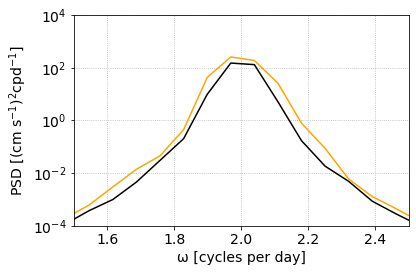

In [184]:
plt.figure()
ax=plt.subplot(111)
plt.semilogy(f, Puu, c='k')
plt.semilogy(f, Puu2, c='orange')

plt.xlabel('ω [cycles per day]')
plt.ylabel('PSD [(cm s$^{-1}$)$^2$cpd$^{-1}$]')
plt.grid(b=True,ls=':')
ax.set_ylim(1e-4, 1e4)
# ax.set_xlim(0.25, 2.75)
ax.set_xlim(1.5, 2.5)

plt.tight_layout()
plt.savefig('../FIGURES/PK2015_psd_tidal_v_{}.png'.format(scenario), dpi=150)

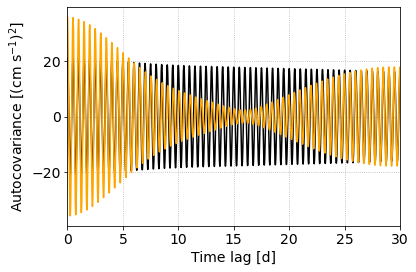

In [185]:
ndays = 30
tau = np.linspace(0.,ndays, int(1/dt_days*ndays+1))


plt.figure()
plt.plot(tau, stattools.acovf( (vraw-vlow)*100, nlag=1/dt_days*ndays),
        color='k', ms=5)

plt.plot(tau, stattools.acovf( (vraw2-vlow2)*100, nlag=1/dt_days*ndays),
        color='orange', ms=5)

plt.ylabel('Autocovariance [(cm s$^{-1}$)$^2$]')
plt.xlabel('Time lag [d]')
plt.grid(b=True, ls=':')
plt.xlim(0, ndays)
plt.tight_layout()

plt.savefig('../FIGURES/PK2015_acovf_v_{}.png'.format(scenario), dpi=150)

# Analytical autocovariance function

$C(\tau)=E[f(t)f(t+\tau)]$

$$
C(\tau) \approx \eta^2 \exp\left(-\lambda_t t\right) \cos(\omega_0 \tau)
$$

This has a spectral density kernel

$$
S(\omega) = \int_{-\infty}^\infty C(\tau)\exp(-i\omega\tau)d\tau = \frac{\eta^2}{(\omega-\omega_0)^2 + \lambda_t ^2}
$$


or

$$
C(\tau) \approx \eta^2 \exp\left(- (\lambda_t t)^2\right) \cos(\omega_0 \tau)
$$

$$
S(\omega) = \int_{-\infty}^\infty C(\tau)\exp(-i\omega\tau)d\tau = \frac{\eta^2}{4\sqrt{2}\lambda_t }
            \exp\left( -\frac{(\omega-\omega_0)^2}{4\lambda_t^2}\right)
$$

```
    2 = np.sqrt(2)
    return a**2/(4*r2*b)* np.exp(-((f-c)**2/(4*b**2)) ) 
```

In [186]:
stattools.acovf( (vraw-vlow)*100, nlag=24*ndays).shape, np.arange(0.,ndays+1/24.,1/24.).shape, 24*ndays+1


((721,), (722,), 721)

<Figure size 432x288 with 0 Axes>

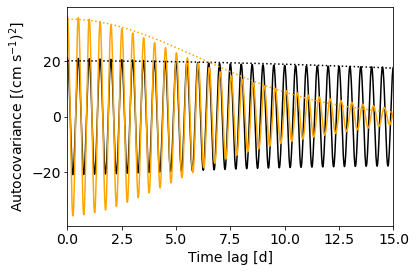

In [187]:
def expcos(tau, params):
    eta, lt, omega0 = params
    b=1/(lt)
    
    return eta**2 * np.exp(-tau*b) * np.cos(omega0 * tau)

def quadexpcos(tau, params):
    eta, lt, omega0 = params
    b = 1/lt
    return eta**2 * np.exp(-(tau*b)**2) * np.cos(omega0 * tau)




ndays=15.0

# tau = np.arange(0.,ndays+1/24.,1/24.)
tau = np.linspace(0.,ndays, int(1/dt_days*ndays+1))

plt.figure()
plt.figure()
plt.plot(tau, stattools.acovf( (vraw-vlow)*100, nlag=1/dt_days*ndays),
        color='k', ms=5)
# plt.plot(tau, exp2cos(tau, (np.sqrt(20), 1/15, 0*2*2*np.pi)) ,'k:')

plt.plot(tau, stattools.acovf( (vraw2-vlow2)*100, nlag=1/dt_days*ndays),
        color='orange', ms=5)

# plt.plot(tau, expcos(tau, (np.sqrt(20), 130, 0*2*np.pi)) ,'k--')
# WP50 parameters
plt.plot(tau, quadexpcos(tau, (np.sqrt(20), 40, 0* 2*2*np.pi)) , c='k', ls=':')
plt.plot(tau, quadexpcos(tau, (np.sqrt(35), 8.5, 0* 2*2*np.pi)) , c='orange', ls=':')

# WP90 parameters
# plt.plot(tau, quadexpcos(tau, (np.sqrt(19), 24, 0* 2*2*np.pi)) , c='k', ls=':')
# plt.plot(tau, quadexpcos(tau, (np.sqrt(40), 2.8, 0* 2*2*np.pi)) , c='orange', ls=':')

# plt.plot(tau, expcos(tau, (np.sqrt(35), 8, 0*2*2*np.pi)) , c='orange', ls='--')

plt.ylabel('Autocovariance [(cm s$^{-1}$)$^2$]')
plt.xlabel('Time lag [d]')

plt.xlim(0, ndays)
plt.tight_layout()

plt.savefig('../FIGURES/PK2015_acovf_v_fit_{}.png'.format(scenario), dpi=150)

See
https://www.wolframalpha.com/input?i=Fourier+transform+calculator&assumption={"F"%2C+"FourierTransformCalculator"%2C+"transformfunction"}+->"a^2+*+e^(-(t*b)^2)*+cos(c*t)"&assumption={"F"%2C+"FourierTransformCalculator"%2C+"variable1"}+->"t"&assumption={"F"%2C+"FourierTransformCalculator"%2C+"variable2"}+->"tau"

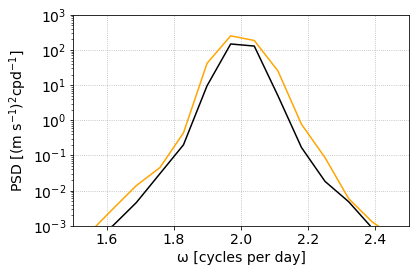

In [188]:
def lorentzian_spectra(f, params):
    """
    Definition from Foreman-Mackey, 2017
    """
    A, lt, T = params
    a = A**2#/(2*np.pi)
    # 2pi is here because we are plotting in cpd, not Hz
    #c = 1/(2*np.pi*lt)
    c = 1/(lt)

    d = 1/T
    
    cff = 1/np.sqrt(2*np.pi)
    dff = np.power((f-d)/c, 2.)
    
    return cff*a/c * (1 / (1+dff))

def expcos_psd(f, params):
    """
    sykulski
    """
    eta, lt, omega0 = params
    c= 1/lt
    return eta**2 / ((f-omega0)**2 + c**2)

def expcos_psd1(f, params):
    """
    zaron
    """
    eta, lt, omega0 = params
    c= 1/(lt)
    return eta**2/ np.pi * c   / ((f-omega0)**2 + c**2)
    
def expcos_psd2(f, params):
    eta, lt, omega0 = params
    lti = 1/lt
    return 1/np.sqrt(twopi) *eta/lti / (1+((f-omega0)/lti)**2 )

def quadexpcos_psd(f, params):
    a, lt, c = params
    b = 1/(lt)
    r2 = np.sqrt(2)
    #return a**2/2 * np.exp(-((f-c)**2/(4*b**2)) ) / (r2*b)+\
    #    a**2/2 * np.exp(-((f+c)**2/(4*b**2)) ) / (r2*b)

    return a**2/2 * np.exp(-((f-c)**2/(2*b**2)) ) / (1*b)+\
        a**2/2 * np.exp(-((f+c)**2/(2*b**2)) ) / (1*b)

# def quadexpcos_psd(f, params):
#     a, lt, c = params
#     b = 1/lt
#     r2 = np.sqrt(2)
#     return a**2/(4*r2*b)* np.exp(-((f-c)**2/(4*b**2)) ) 
##     return a**2/(r2*b)* np.exp(-((f-c)**2/(4*b**2)) ) 

twopi = 2*np.pi
nperseg = 1024
y = vraw*100
f, Puu= signal.welch(y-y.mean(), fs=1/dt_days, nperseg=nperseg)

y = vraw2*100 
f, Puu2 = signal.welch(y-y.mean(), fs=1/dt_days, nperseg=nperseg)

plt.figure()
ax=plt.subplot(111)
plt.semilogy(f, Puu, c='k')
plt.semilogy(f, Puu2, c='orange')
plt.xlabel('ω [cycles per day]')
plt.ylabel('PSD [(m s$^{-1}$)$^2$cpd$^{-1}$]')
plt.grid(b=True,ls=':')
ax.set_ylim(1e-3, 1e3)
ax.set_xlim(1.5, 2.5)
plt.tight_layout()
plt.savefig('../FIGURES/PK2015_psd_v_nofit_{}.png'.format(scenario), dpi=150)

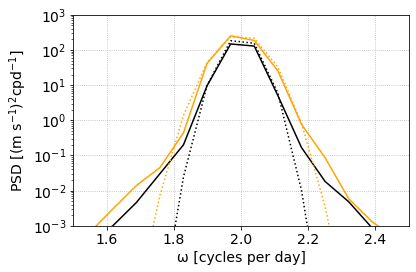

In [202]:
plt.figure()
ax=plt.subplot(111)
plt.semilogy(f, Puu, c='k')
# plt.semilogy(f,  expcos_psd(f, (1, 1/20, 2)) , c='orange',ls=':')

plt.semilogy(f, Puu2, c='orange')
# plt.semilogy(f,  expcos_psd1(f, (np.sqrt(20), 50, 2)) , c='k',ls=':')
# plt.semilogy(f,  expcos_psd1(f, (np.sqrt(35), 40, 2)) , c='orange',ls=':')

plt.semilogy(f,  quadexpcos_psd(f, (np.sqrt(20), 25, 2)) , c='k',ls=':')
plt.semilogy(f,  quadexpcos_psd(f, (np.sqrt(30), 19, 2)) , c='orange',ls=':')

# Wp90
# plt.semilogy(f,  quadexpcos_psd(f, (np.sqrt(20), 25, 2)) , c='k',ls='--')
# plt.semilogy(f,  quadexpcos_psd(f, (np.sqrt(40), 10, 2)) , c='orange',ls='--')

plt.xlabel('ω [cycles per day]')
plt.ylabel('PSD [(m s$^{-1}$)$^2$cpd$^{-1}$]')
plt.grid(b=True,ls=':')
ax.set_ylim(1e-3, 1e3)
ax.set_xlim(1.5, 2.5)
plt.tight_layout()
plt.savefig('../FIGURES/PK2015_psd_v_expquad_fit_{}.png'.format(scenario), dpi=150)

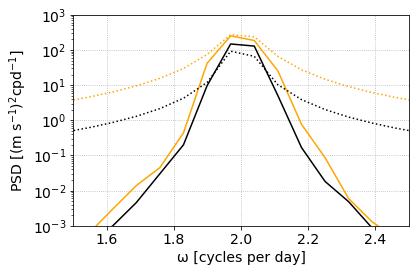

In [203]:
plt.figure()
ax=plt.subplot(111)
plt.semilogy(f, Puu, c='k')
# plt.semilogy(f,  expcos_psd(f, (1, 1/20, 2)) , c='orange',ls=':')

plt.semilogy(f, Puu2, c='orange')
plt.semilogy(f,  expcos_psd1(f, (np.sqrt(20), 50, 2)) , c='k',ls=':')
plt.semilogy(f,  expcos_psd1(f, (np.sqrt(60), 20, 2)) , c='orange',ls=':')

#plt.semilogy(f,  quadexpcos_psd(f, (np.sqrt(20), 50, 2)) , c='k',ls='--')
#plt.semilogy(f,  quadexpcos_psd(f, (np.sqrt(35), 40, 2)) , c='orange',ls='--')

plt.xlabel('ω [cycles per day]')
plt.ylabel('PSD [(m s$^{-1}$)$^2$cpd$^{-1}$]')
plt.grid(b=True,ls=':')
ax.set_ylim(1e-3, 1e3)
ax.set_xlim(1.5, 2.5)
plt.tight_layout()
plt.savefig('../FIGURES/PK2015_psd_v_exp_fit_{}.png'.format(scenario), dpi=150)

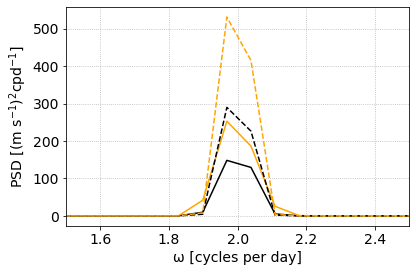

In [204]:
plt.figure()
ax=plt.subplot(111)
plt.plot(f, Puu, c='k')
# plt.semilogy(f,  expcos_psd(f, (1, 1/20, 2)) , c='orange',ls=':')

plt.plot(f, Puu2, c='orange')
# plt.plot(f,  expcos_psd1(f, (np.sqrt(30), 50, 2)) , c='k',ls=':')
# plt.plot(f,  expcos_psd1(f, (np.sqrt(55), 30, 2)) , c='orange',ls=':')

plt.plot(f,  quadexpcos_psd(f, (np.sqrt(30), 30, 2)) , c='k',ls='--')
plt.plot(f,  quadexpcos_psd(f, (np.sqrt(55), 30, 2)) , c='orange',ls='--')

plt.xlabel('ω [cycles per day]')
plt.ylabel('PSD [(m s$^{-1}$)$^2$cpd$^{-1}$]')
plt.grid(b=True,ls=':')
# ax.set_ylim(1e-3, 1e3)
ax.set_xlim(1.5, 2.5)
plt.tight_layout()
# plt.savefig('../FIGURES/PK2015_psd_v_exp_fit_{}.png'.format(scenario), dpi=150)

In [1]:
#!pip install --user sympy
import sympy as sp

In [24]:
# x=sp.symbols('x')
from sympy.abc import x, k
omega = sp.symbols('omega')
eta = sp.symbols('eta')
b = sp.symbols('b')
c= sp.symbols('c')

expr=eta**2 * sp.exp(-b*x) * sp.cos(c*x) #*sp.exp(-1j*omega*x)
#sp.integrate(expr,(x,0,sp.oo) )
sp.fourier_transform(expr, x, k)

eta**2*FourierTransform(exp(-b*x)*cos(c*x), x, k)

In [16]:
sp.im(1j)

1.00000000000000